In [5]:
!pip install Arch
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00


In [6]:
# loading relevant libraires
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from scipy.stats import pearsonr
from arch import arch_model
import statsmodels as sm
import pmdarima
from pylab import rcParams
plt.rcParams["figure.figsize"] = (20,20)

In [7]:
# loading data
df = pd.read_csv('BTC-USD.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [8]:
# dropping unnecessary columns
df = df[['Date', 'Close']]

In [9]:
#checking for missing values
df.isnull().sum()

Date     0
Close    0
dtype: int64

In [10]:
# converting 'Date' to date format
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
# setting date as index
df.set_index('Date', drop= True, inplace = True)

## ARMA, ARIMA, ARCH, GARCH

We will first discuss **ARMA** and **ARIMA** as they are almost similar except one difference.

## ARMA
**ARMA = Auto Regressive + Moving Average**

**Auto Regressive** is denoted by **p** and it denotes that on **how many previous periods values (lags) the current value (forecast) is dependent on**.


**Moving Average** is denoted by **q** and it denotes that on **how many previous periods errors (lags) the current shock is dependent on**.


## ARIMA
ARIMA and ARMA are almost same. The only difference is of 'I' which means integrated (difference). ARIMA is used only when the series is non stationary.

**ARIMA = Auto Regressive + Integrated+  Moving Average**

**Integrated** is denoted by **d** and it denotes that on **how many times we need to take the difference of the series in order to make it stationary**. It is generally inferred from the **timeseries plot and ADF test**

It must be noted that **ARIMA is used when the series is non stationary**

If the timeseries has any trend (increasing or decreasing) as in the plot below, we can be sure that the timeseries is non stationary without even conducting ADF test

![image.png](attachment:image.png)

However, if a timeseries does not have any trend just in the case of he plot below, we can say that the timeseries is stationary. However, **statistical test (ADF)** will still be necessary to check stationarity.

![image-2.png](attachment:image-2.png)

**ADF test** is also known as unit root test which shows statistically whether the timeseries is stationary or not. If the timeseries is not stationary, then we will use a higher order of I (order of difference) to make it stationary.

The ADF test has the following hypothesis

H0: The time series is non-stationary.

HA: The time series is stationary.

so if the p value is less than
0.05 then we can be 95% sure that the timeseries is stationary.

## ARCH and GARCH
ARCH refers to autoregressive conditionally heteroscedastic and GARCH refers to Generalized autoregressive conditionally heteroscedastic.

*We do not apply these models by choice as there are very strong assumptions behind each of these models. We follow a protocol provided by the **Box Jenkins** to see which model is suitable for a perticular timeseries*.

## Box-Jenkins Model
It is comprised on 4 steps:

1. lags determination

    a. Check for stationarity (I) by timeseries plot and ADF test

    b. determine p

    c. determine q

If the model is stationary, it means that I=0 i.e. ARIMA will become ARMA.

2. Estimate the model parameters by fitting ARIMA or ARMA.

3. Calculate the residuals (errors).We need to prove that the residuals are a white noise by checking the following 3 conditions.

    a. Mean = 0

    b. Variance = constant

    c.  conditional heteroscedasticity = 0 (by ARCH test)

4. Forecasting. We can go to forecast only if the above 3 conditions are fulfilled else we will have to go with the ARCH or the GARCH models


## Box-Jenkins Application

### 1. lags determination

#### a. Stationarity check

Timeseries plot


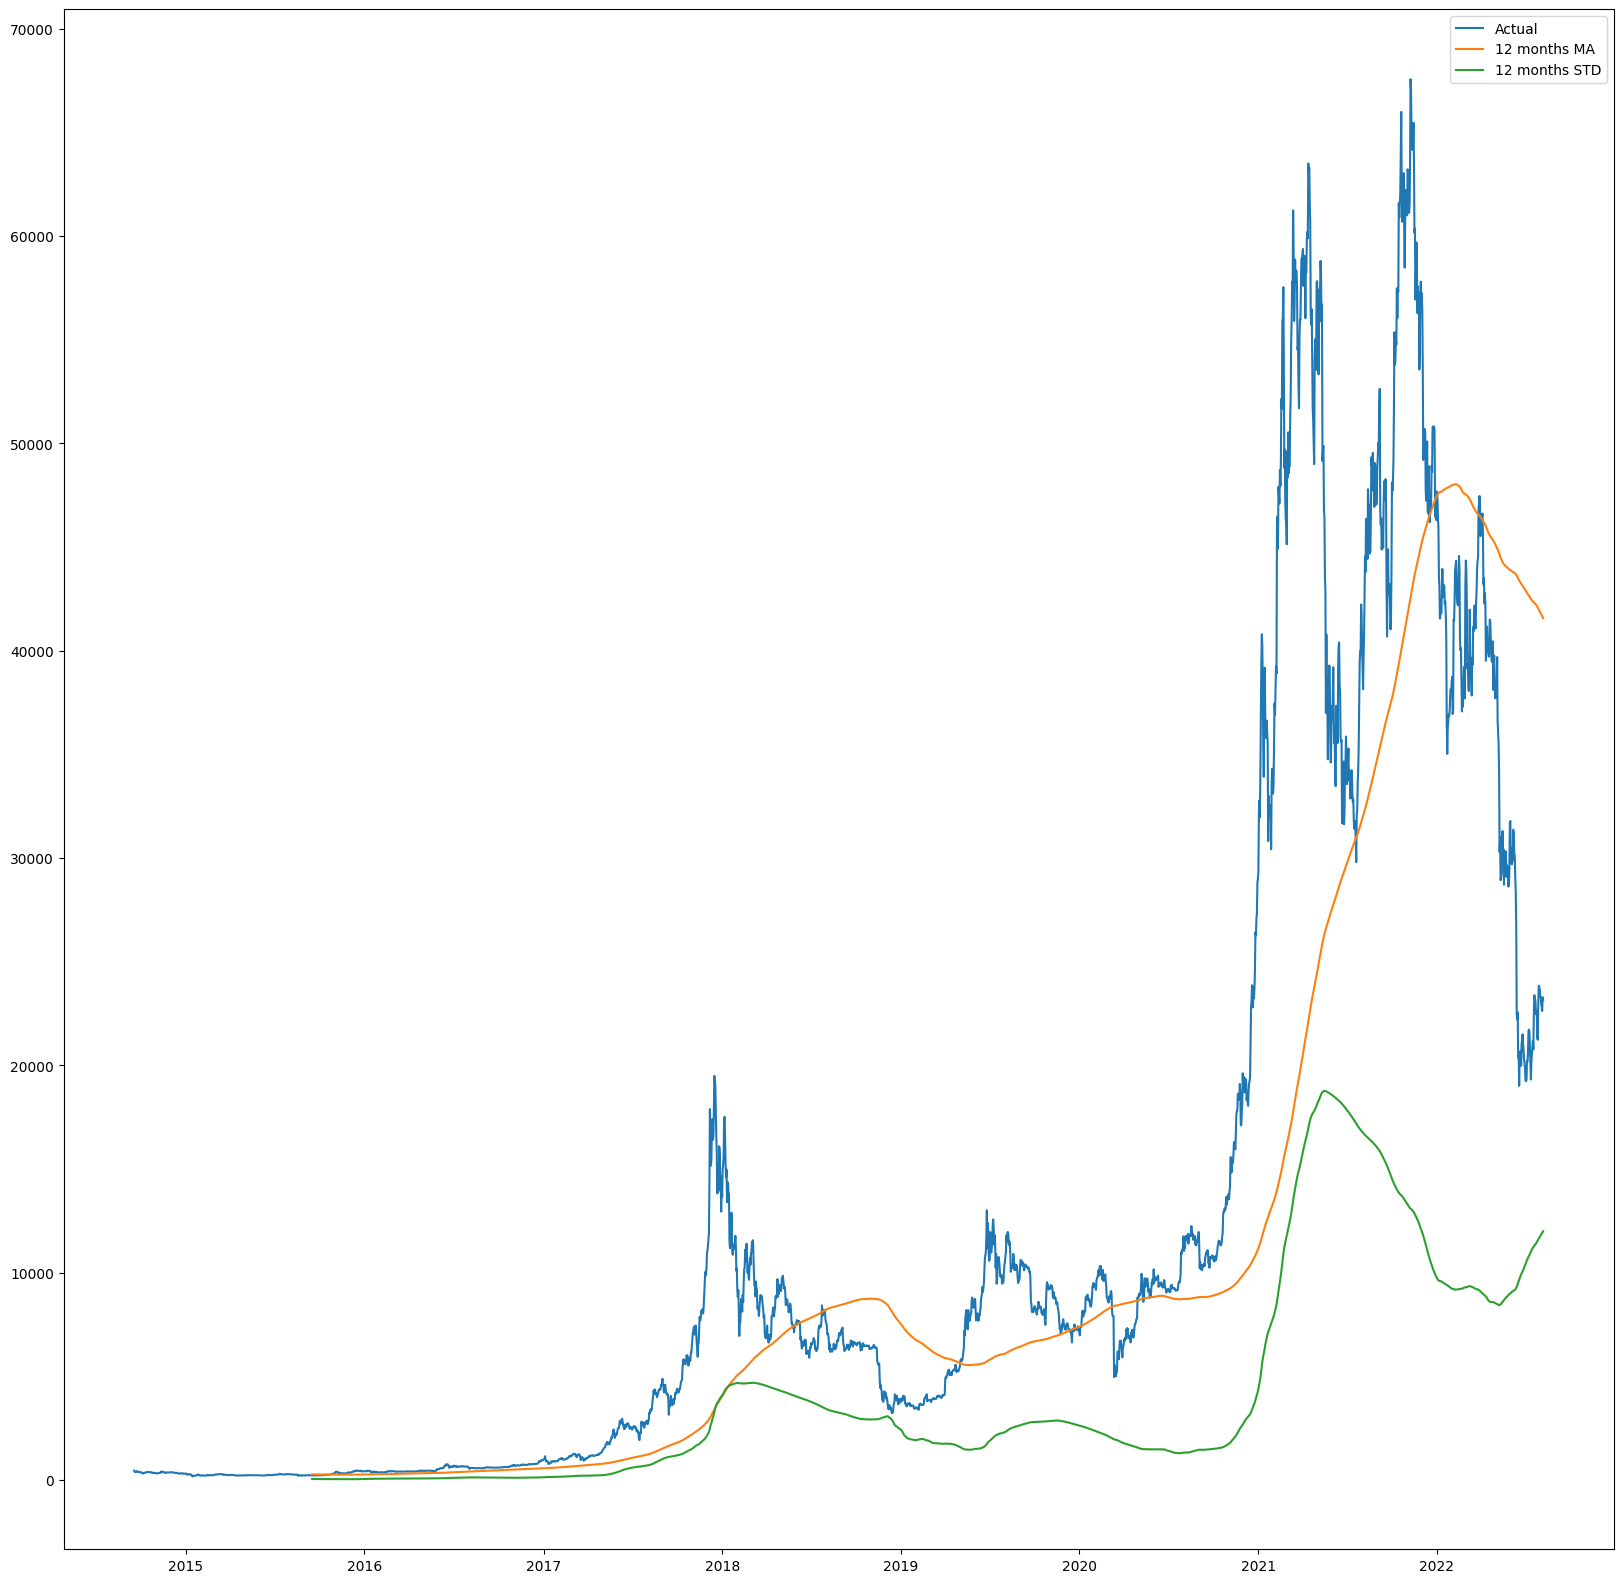

In [42]:
#plotting the timeseries
print('Timeseries plot')
plt.plot(df, label = 'Actual')
plt.plot(df.rolling(window=365).mean(), label = '12 months MA')
plt.plot(df.rolling(window=365).std(), label = '12 months STD')
plt.legend()

From the above visual we see that there is clear trend in the data.The variance and the standard deviation also seem to be variable. However to further confirm this, we will conduct ADF test

In [13]:
result = adfuller(df)
print('ADF TEST \n')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF TEST 

ADF Statistic: -1.606233
p-value: 0.480462
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


From the above summary, p value = 0.5 and t value = -1.6

At p-value > alpha = 0.05, we cannot reject the null hypothesis at 95% confidence level.

The series is non stationary at d = 0.


#### Repeating the above step at d = 1 (Returns)

In [14]:
# d = 1
df1 = df.diff()
df1.dropna(inplace = True)

Timeseries plot


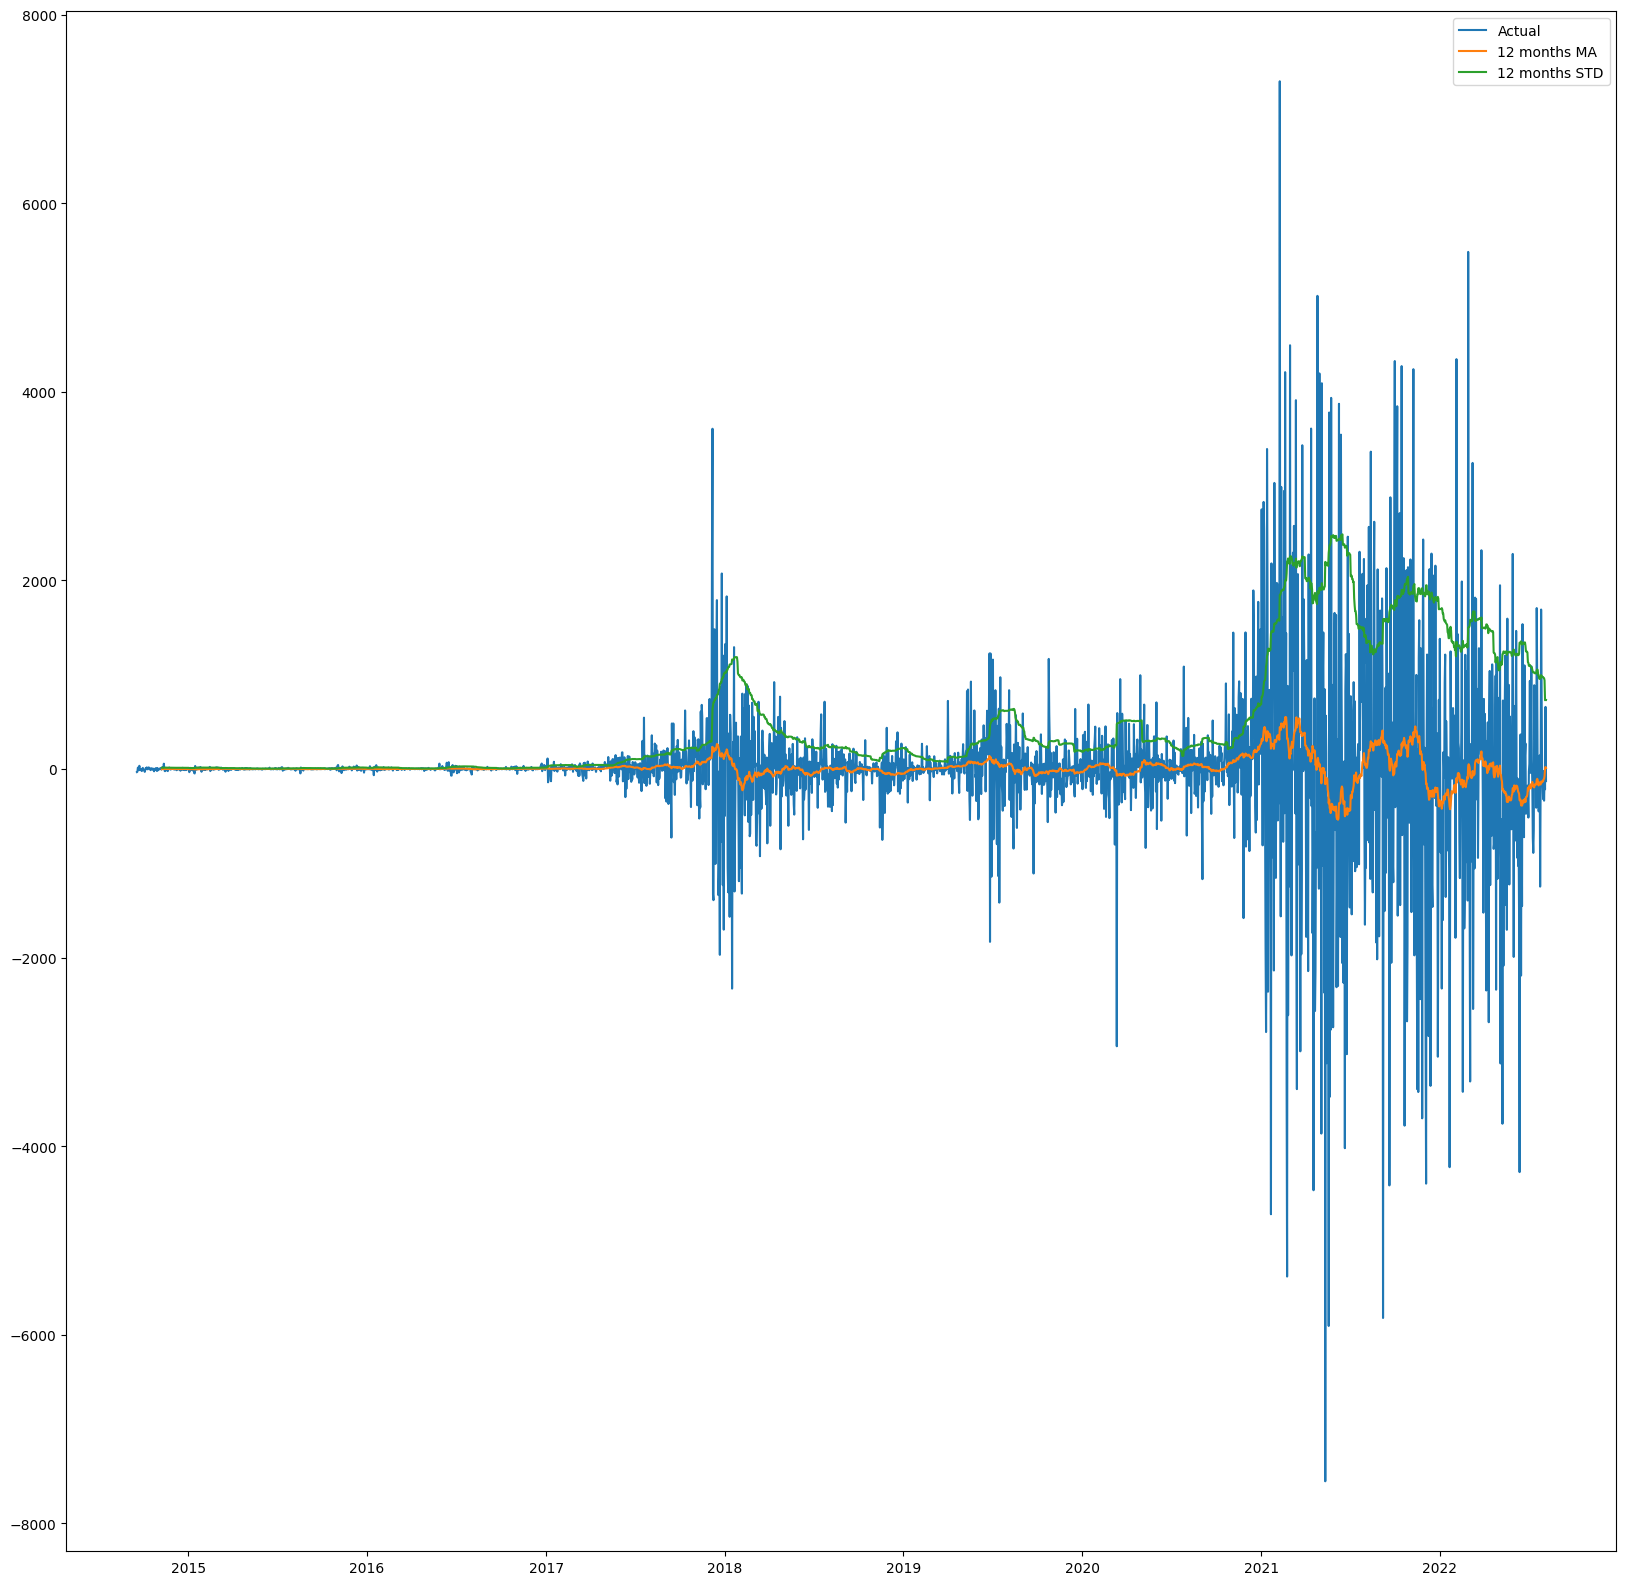

In [15]:
#plotting the timeseries
print('Timeseries plot')
plt.plot(df1, label = 'Actual')
plt.plot(df1.rolling(window=52).mean(), label = '12 months MA')
plt.plot(df1.rolling(window=52).std(), label = '12 months STD')
plt.legend()

In [16]:
result = adfuller(df1)
print('ADF TEST \n')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF TEST 

ADF Statistic: -8.908620
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


From the above summary, p value = 0.000 and t value = -8.9

At p-value < alpha = 0.05, we can reject the null hypothesis at 95% confidence level.

The series is stationary at d = 1.

#### b. determine p

Text(0.5, 1.0, 'PACF Plot')

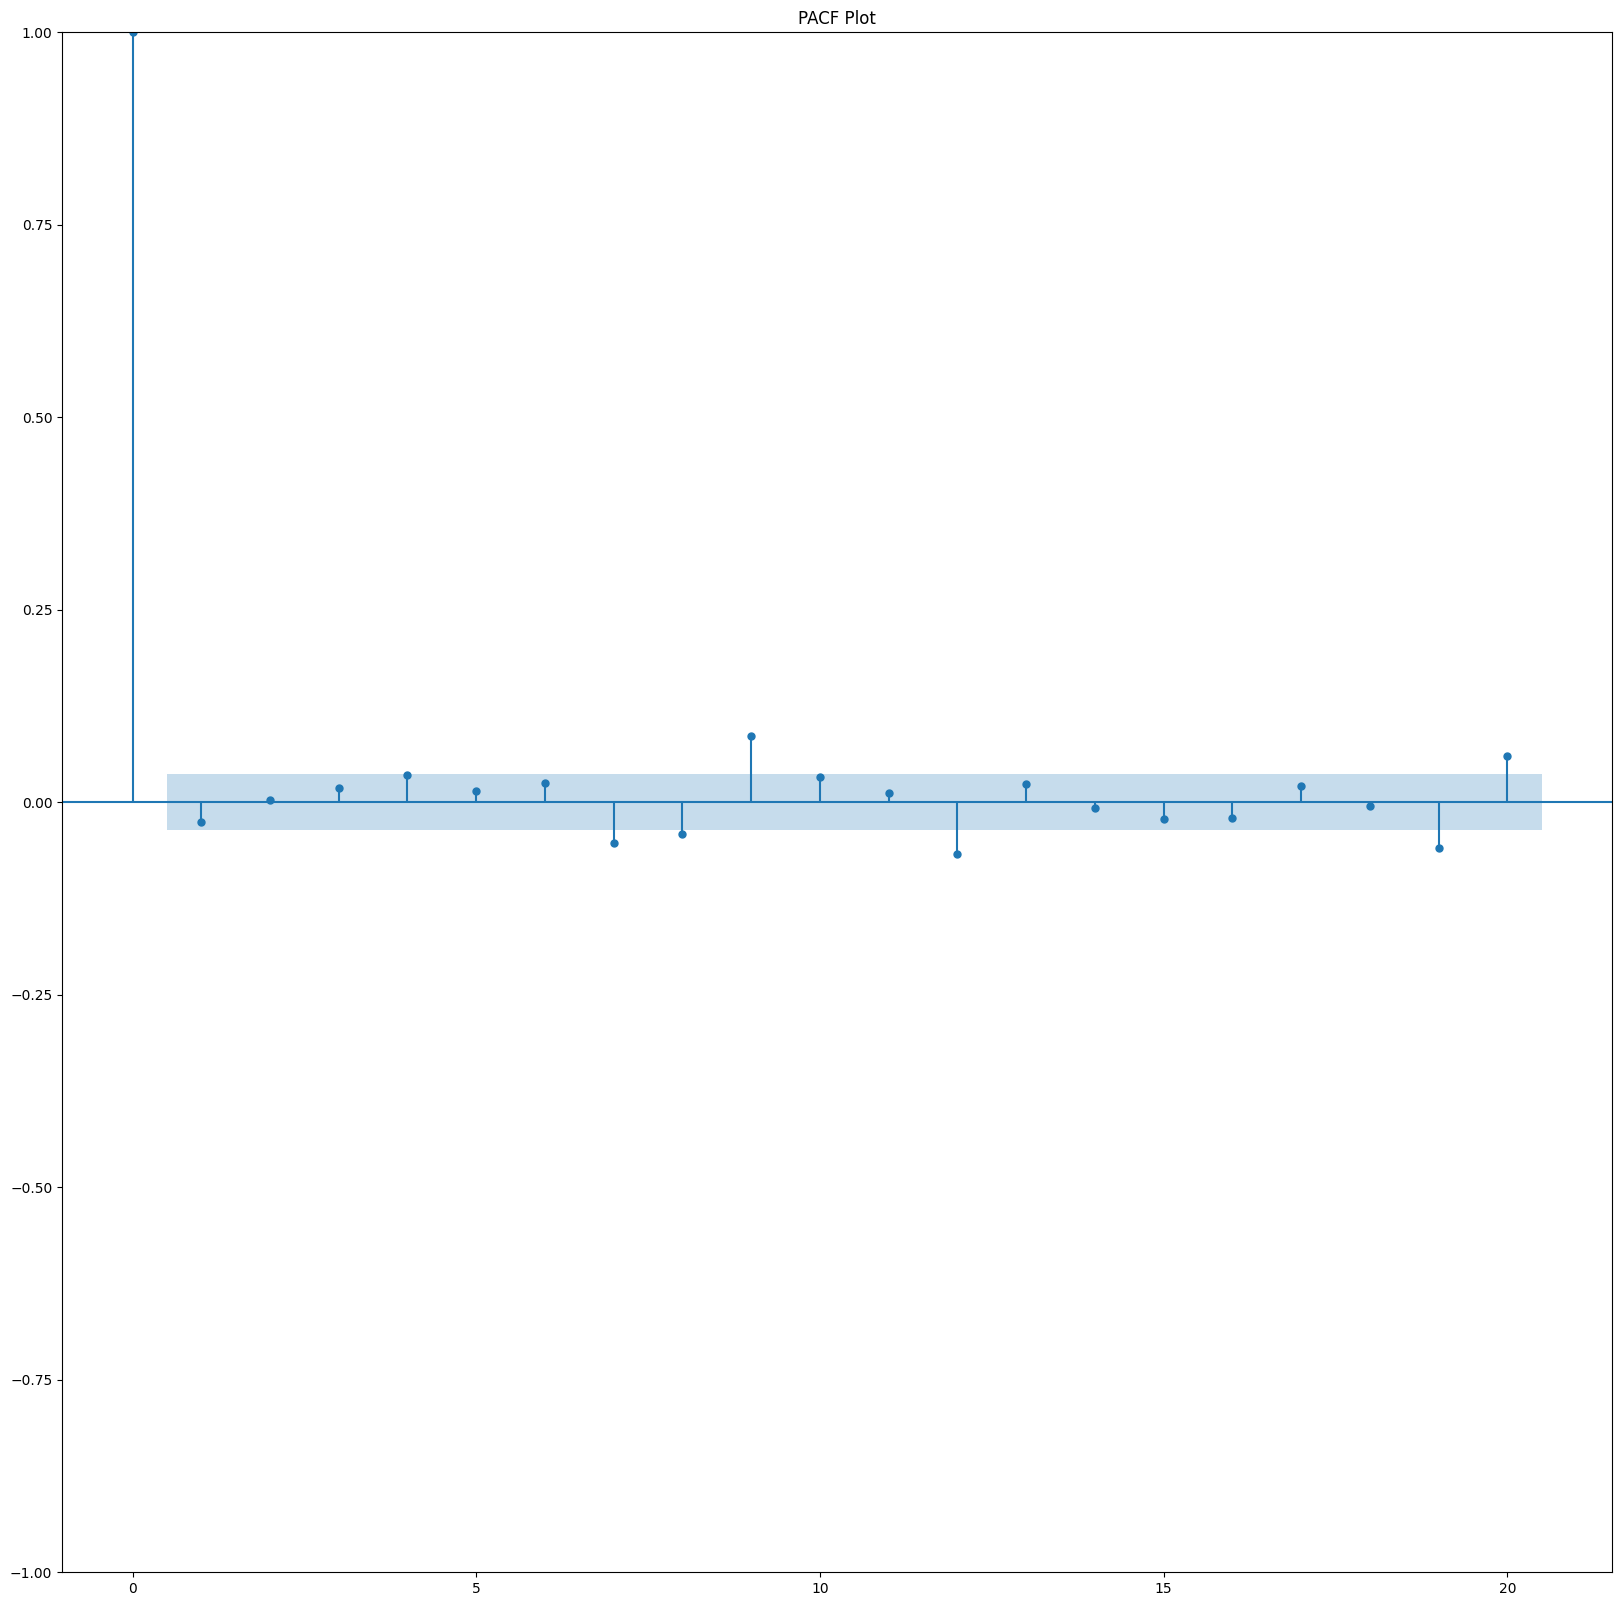

In [17]:
#PACF plot
plot_pacf(df1,lags = 20)
plt.title("PACF Plot")

This shows some kind of seasonality in the data

#### c. determine q

Text(0.5, 1.0, 'ACF Plot')

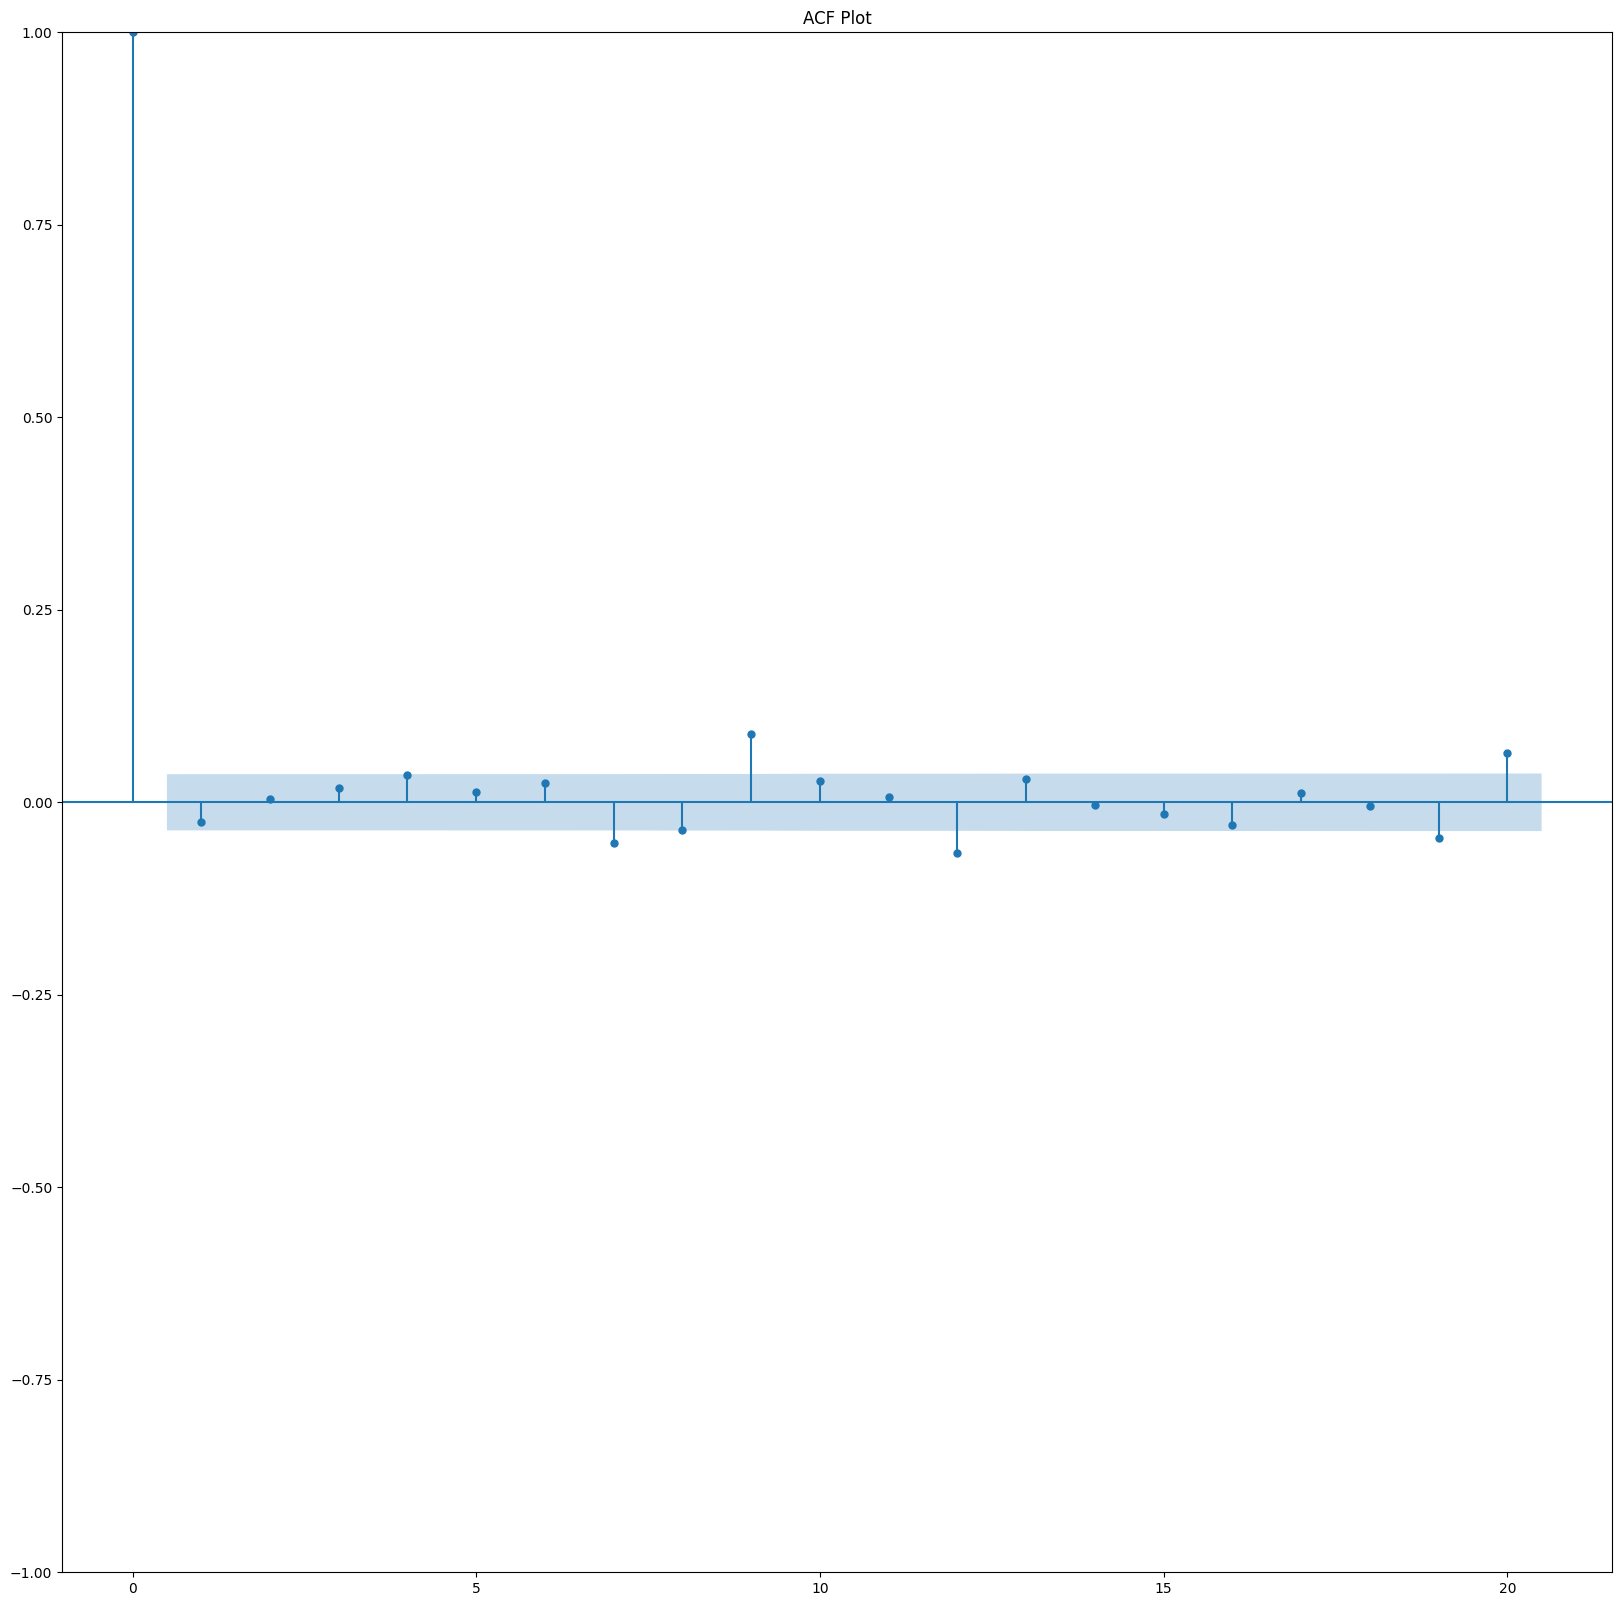

In [18]:
#PACF plot
plot_acf(df1,lags = 20)
plt.title("ACF Plot")

This also confirms that there is a seasonality in the data.

Now using **stepwise auto ARIMA** to find the best lags with respect to AIC

In [ ]:
# fitting a stepwise model:
stepwise_fit = pmdarima.auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic


### 2. Paramter estimation by by Fitting the model
We are using statsmodel for application of ARIMA

In [20]:
# fitting the model on the timeseries data with specified lags
model = ARIMA(df,  order=(1,1,1),  seasonal_order=(2, 1, 0, 12))
results = model.fit()

In [21]:
# checking the summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 2881
Model:             ARIMA(1, 1, 1)x(2, 1, [], 12)   Log Likelihood              -23653.856
Date:                           Thu, 22 Aug 2024   AIC                          47317.711
Time:                                   11:42:18   BIC                          47347.518
Sample:                               09-17-2014   HQIC                         47328.457
                                    - 08-06-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9663      0.002   -390.405      0.000      -0.971      -0.961
ma.L1          0.9999      0.008    127.704      0.000       0.985       1.015
ar.S.L12      -0.7182      0.008    -90.594      0.000      -0.734      -0.703
ar.S.L24      -0.2789      0.009    -31.201      0.000      -0.296      -0.261
sigma2       8.52e+05      1e+04     85.128      0.000    8.32e+05    8.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.48   Jarque-Bera (JB):             25496.14
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):            4446.65   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3. Residuals Diagnostic Checking

In [22]:
# calculation of errors (residuals)
residuals = results.resid

#### a. Mean = 0

#### b. Variance = constant

to check mean and variance, we will plot the residuals


Residual plot


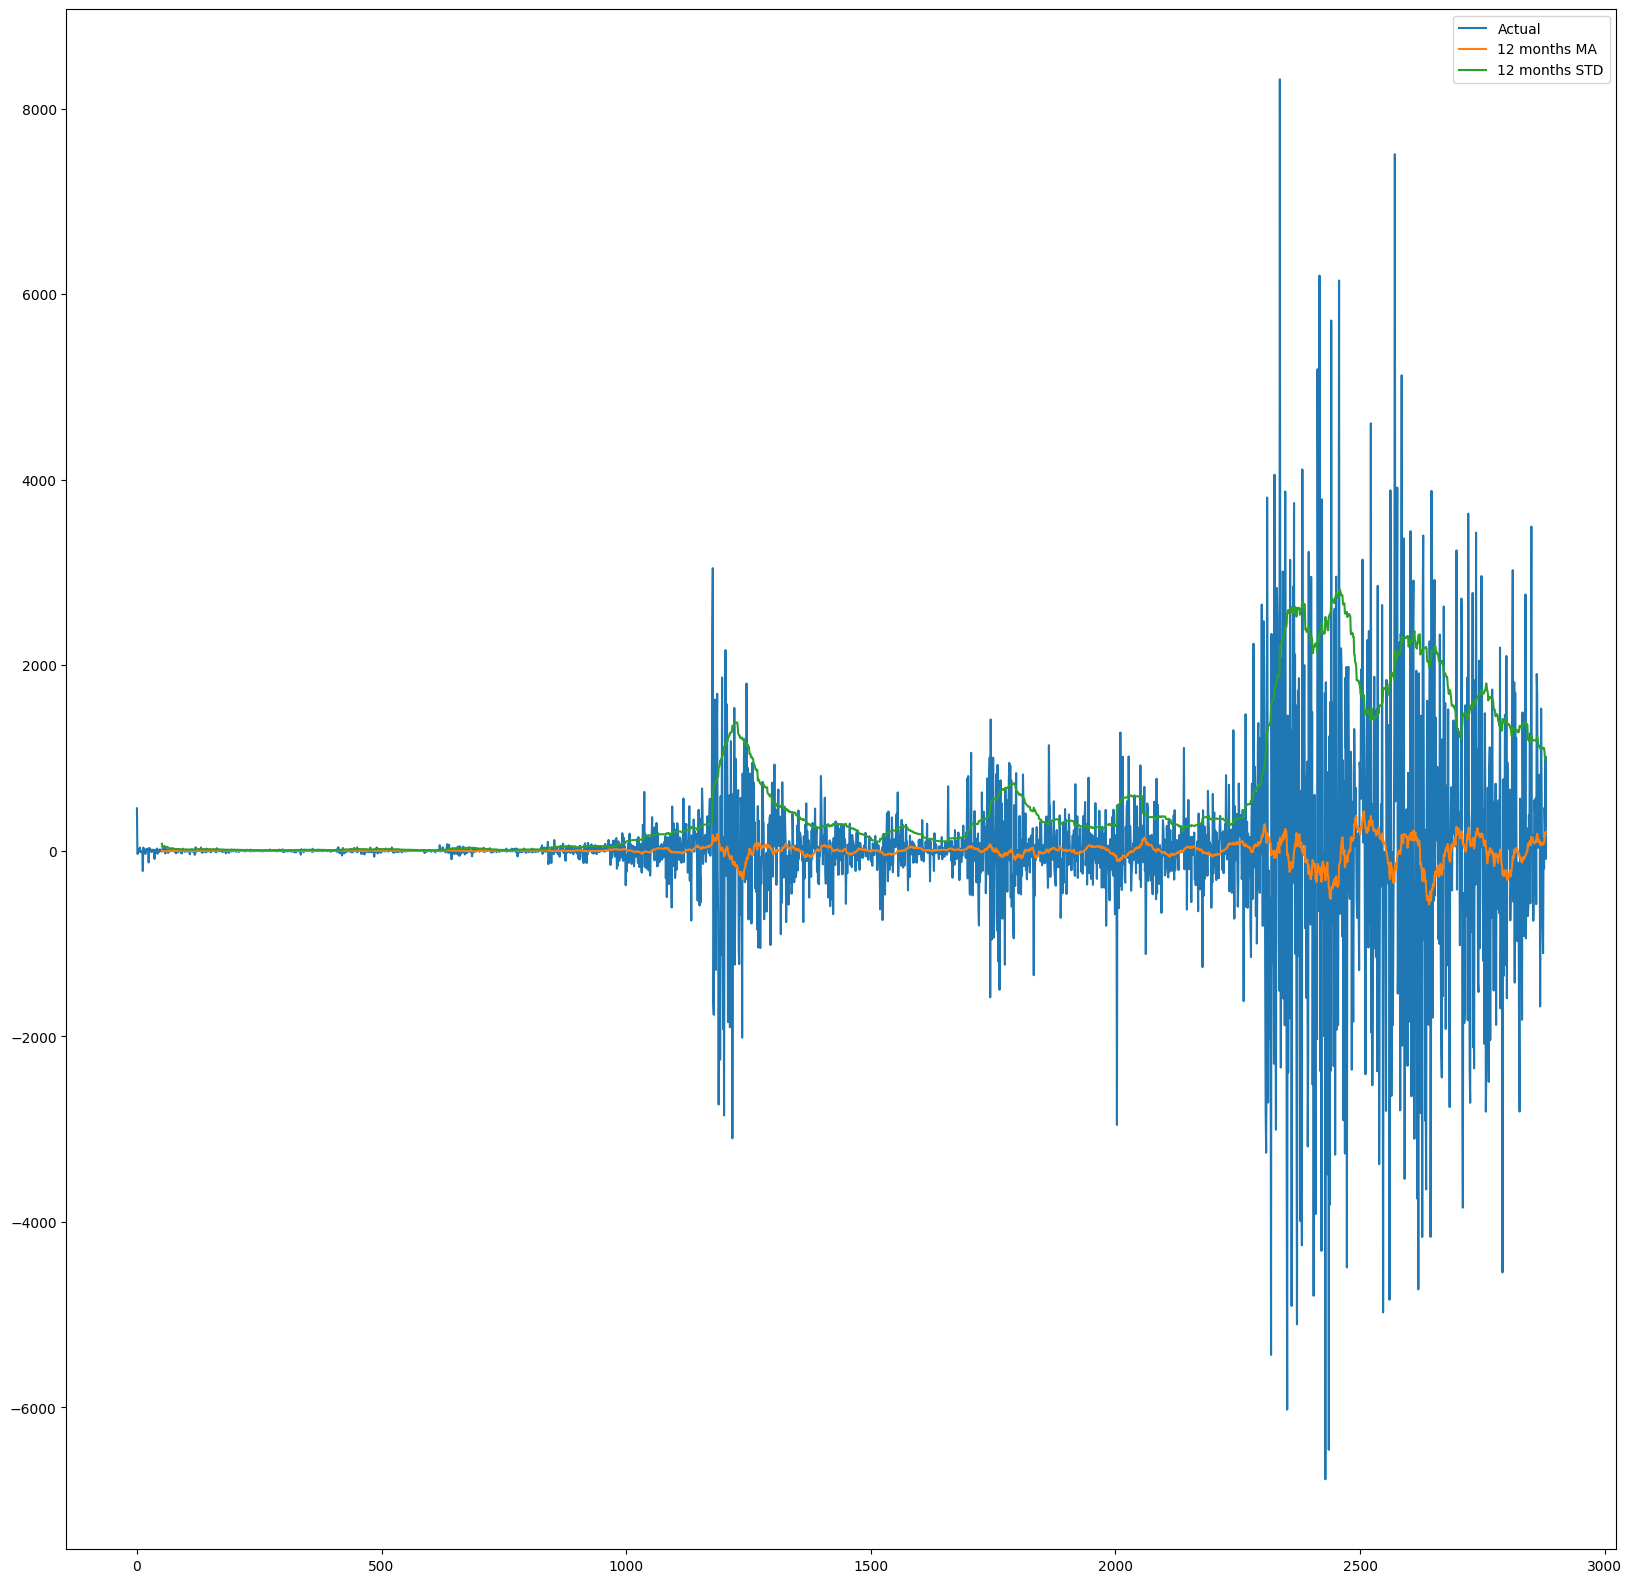

In [23]:
print('Residual plot')
plt.plot(residuals.values, label = 'Actual')
plt.plot(residuals.rolling(window=52).mean().values, label = '12 months MA')
plt.plot(residuals.rolling(window=52).std().values, label = '12 months STD')
plt.legend()

we can see that the mean of this plot is almost about 0 but the variance is changing

#### c.  conditional heteroscedasticity (ARCH effects)

In [24]:
# arch test
sm.stats.diagnostic.het_arch(residuals, nlags=None, store=False, ddof=0)

(530.4806553726188,
 1.3443438564142992e-107,
 64.82213778101584,
 2.7868618910210007e-119)

Engle's ARCH test assesses the null hypothesis that a series of residuals (rt) exhibits no conditional heteroscedasticity (ARCH effects), against the alternative that there is a conditional hetroscedasticity in the residuals.

The p value < alpha = 0.05 which means that we can reject the null hypothesis at 95% confidence level.

The series of residuals (rt) exhibits conditional heteroscedasticity (ARCH effects)

Conditions b and c are not satisfied hence we can not proceed onto forecasting using ARIMA or ARMA.

### Solution:
Since the variance is not constant and there is a conditional heteroscedasticity, hence **ARCH** or **GARCH** can be an optimal solution

# ARCH and GARCH

### Hypothesis:

The ARCH model can assist us in identifying the underlying volatility in the data, whereas the GARCH model can assist us in identifying the effects of price shocks. Based on these models, I predict that Bitcoin's Value at Risk will have a Gaussian distribution. This means that the probability of experiencing a loss or gain in Bitcoin's value is roughly equal across all values. However, there is a greater likelihood of experiencing a loss early in Bitcoin's history, and a lower likelihood of experiencing a loss later in its history. Overall, this suggests that the value of Bitcoin is relatively unstable, with the potential for large price swings.

The ARCH or Autoregressive Conditional Heteroskedasticity method provides a way to model a change in variance in a time series that is time dependent, such as increasing or decreasing volatility. An extension of this approach named GARCH or Generalized Autoregressive Conditional Heteroskedasticity allows the method to support changes in the time dependent volatility, such as increasing and decreasing volatility in the same series.

### Note
We need to provide a *mean equation* to both the ARCH and the Garch models as they can only model the *variance*. The mean equation has to be estimated from the *Box Jenkins methodology* discussed above.

The best model for mean estimation using Box Jenkins methodology is : **ARIMA(0,1,0)(2,1,0)[12]**

We will be using *Arch library* in Python for applying Arch and the Garch models.

The Arch library has the following options to estimate the mean:


![image.png](attachment:image.png)

So we can not use our shortlisted model directly as a mean using Python.

So We will use ARIMA(0,1,0)(2,1,0)[12] to forecast the mean. Then we will use ARCH and Garch on the residuals to model them.

lets check that what is the mean of the residuals that came out from the ARIMA(0,1,0)(2,1,0)[12]

In [25]:
print(f'Mean of residuals from ARIMA(0,1,0)(2,1,0)[12]: {np.mean(residuals)}')

Mean of residuals from ARIMA(0,1,0)(2,1,0)[12]: 1.0068443543614243


The mean of residuals is almost zero. So we can use the mean parameter in the Arch library as zero.

Since the Arch and the Garch models assume stationarity, lets check whether the residuals are stationary or not

In [26]:
result = adfuller(residuals)
print('ADF TEST \n')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF TEST 

ADF Statistic: -11.638772
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


From the above summary, p value = 0.000 and t value = -11.63

At p-value < alpha = 0.05, we can reject the null hypothesis at 95% confidence level.

The residuals are statioanry using ARIMA

### Lags determination for ARCH and Garch

Text(0.5, 1.0, 'PACF Plot')

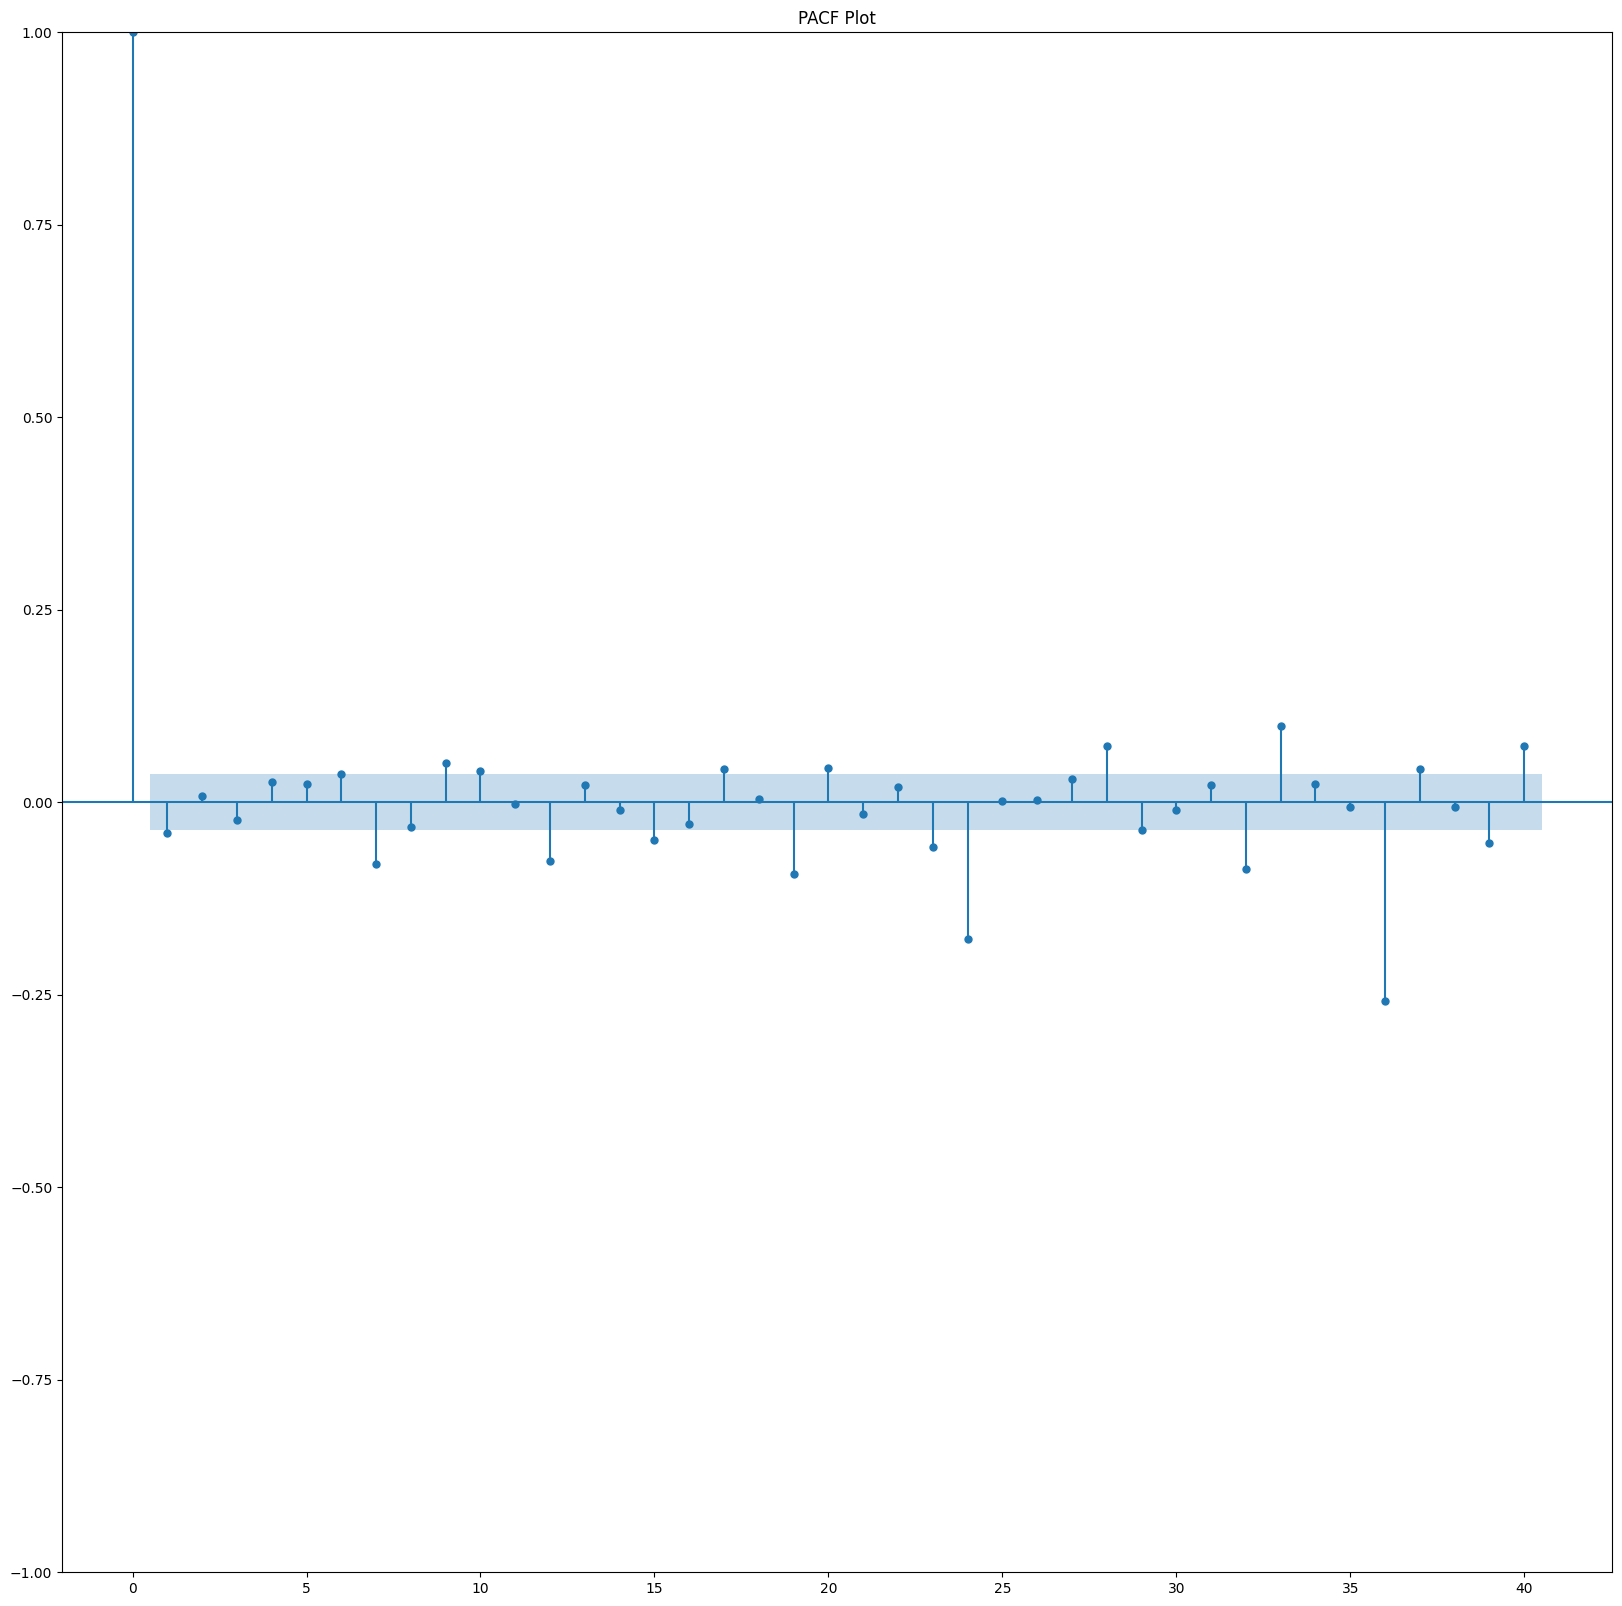

In [27]:
#PACF plot
plot_pacf(residuals,lags = 40)
plt.title("PACF Plot")

Text(0.5, 1.0, 'PACF Plot')

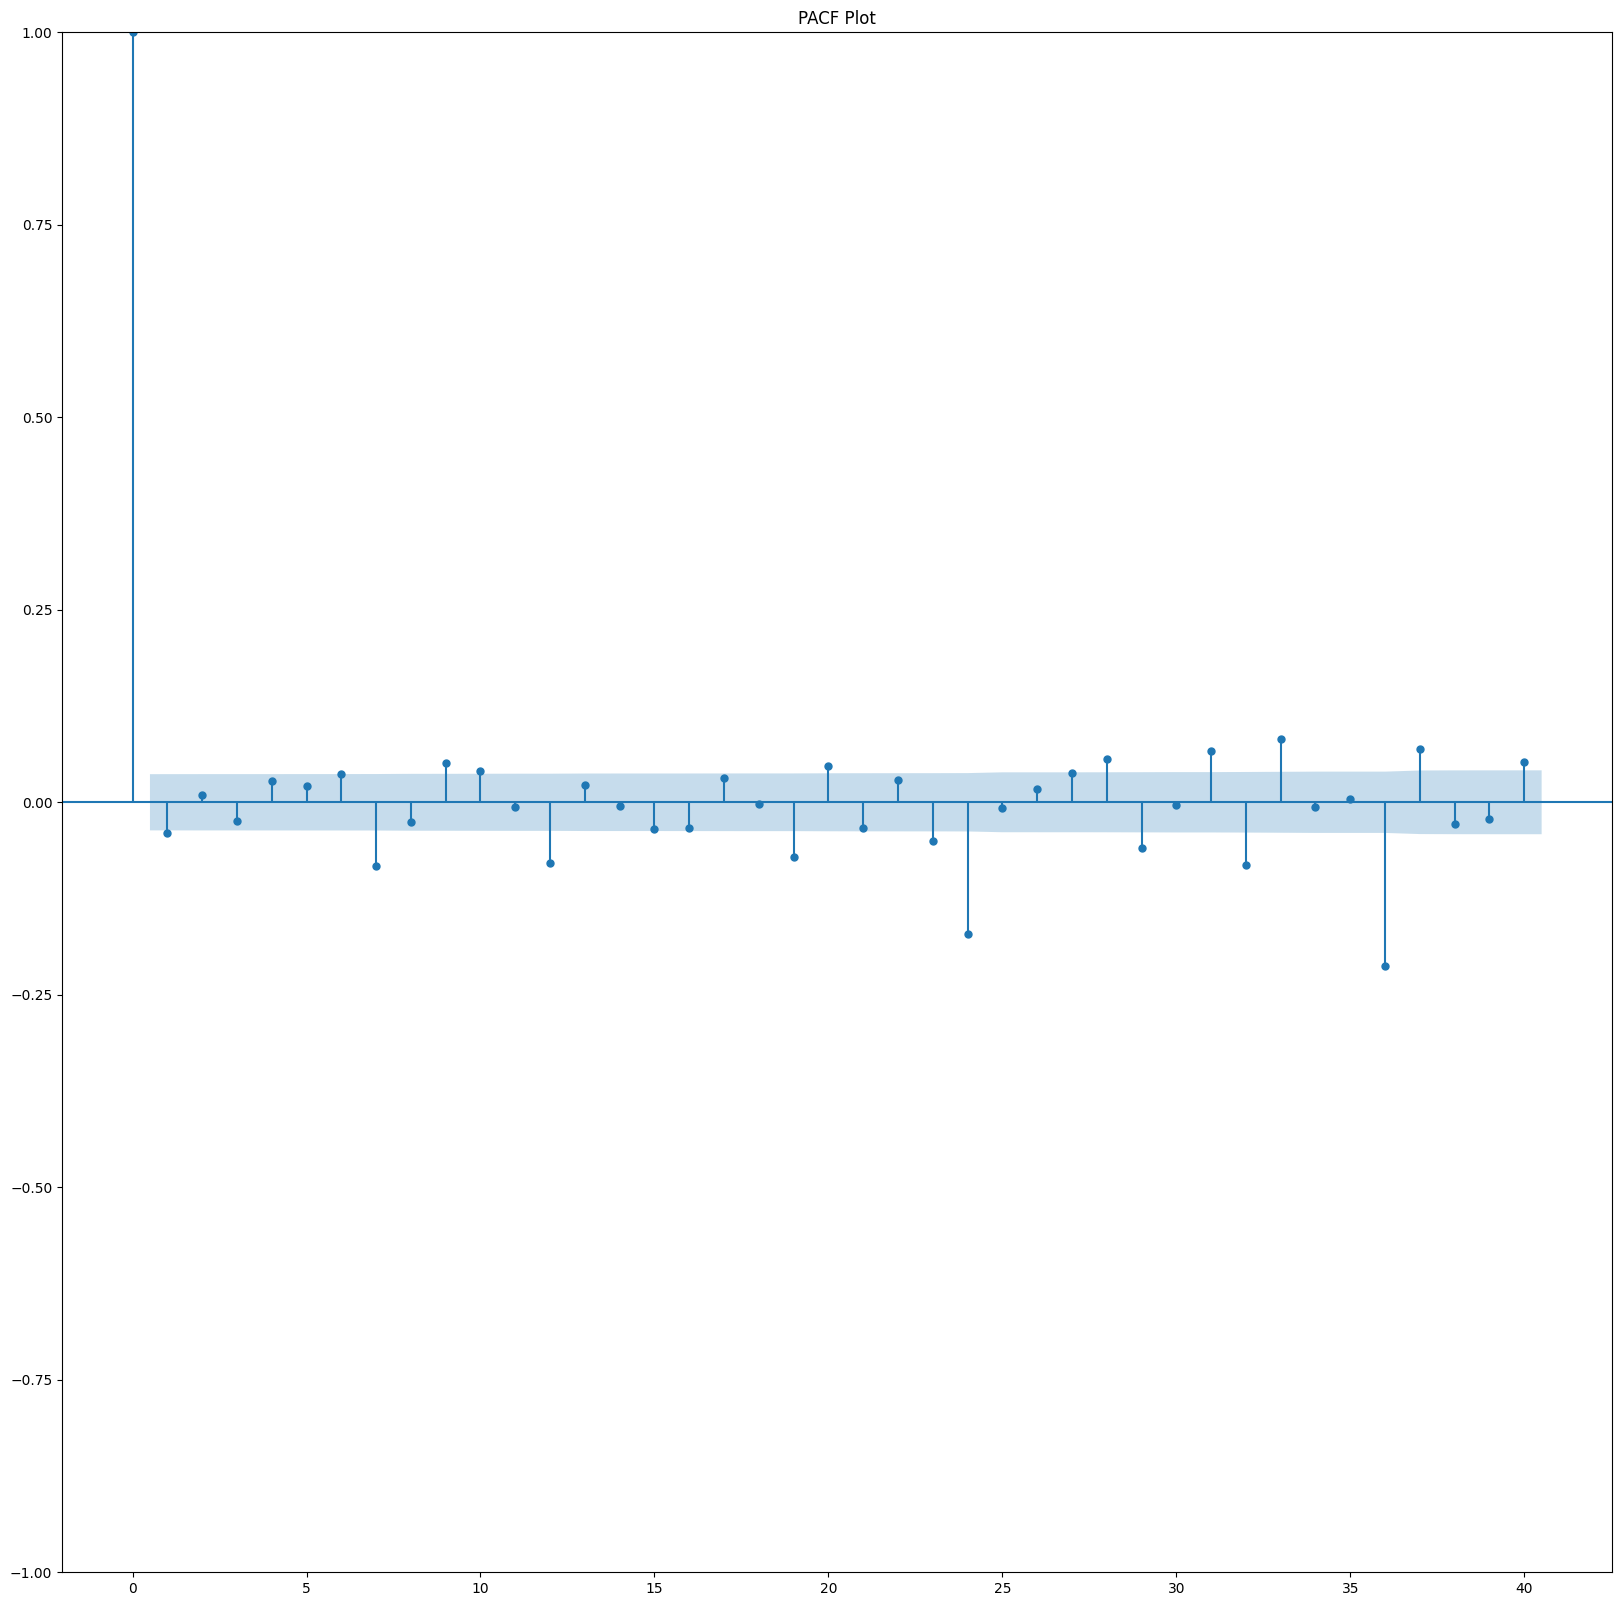

In [28]:
#ACF plot
plot_acf(residuals,lags = 40)
plt.title("PACF Plot")

ACF and PACF cuts off after 1 lag. However, there are some significant lags afterwards as well.

# Arch
### lets check the ARCH model at different values of 'p' and 'mean and select the best one as per AIC and BIC

P = 1 and mean = Zero

In [29]:
model_arch = arch_model(residuals, mean = "zero", vol = "ARCH", p = 1, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Iteration:      5,   Func. Count:     21,   Neg. LLF: 21581.085959528136
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21581.08593816481
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Zero Mean - ARCH Model Results                              
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                   ARCH   Log-Likelihood:               -21581.1
Distribution:      Generalized Error Distribution   AIC:                           43168.2
Method:                        Maximum Likelihood   BIC:                           43186.1
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2881
Time:                                    11:42:19   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1196e+05  1.994e+04     10.628  2.199e-26 [1.729e+05,2.510e+05]
alpha[1]       1.0000  9.578e-02     10.441  1.609e-25     [  0.812,  1.188]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.676e-02     21.601 1.748e-103 [  0.918,  1.102]
========================================================================

Covariance estimator: robust
"""

P = 1 and mean = constant

In [30]:
model_arch = arch_model(residuals, mean = "constant", vol = "ARCH", p = 1, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 21580.937107777652
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Constant Mean - ARCH Model Results                            
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                   ARCH   Log-Likelihood:               -21580.9
Distribution:      Generalized Error Distribution   AIC:                           43169.9
Method:                        Maximum Likelihood   BIC:                           43193.7
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2880
Time:                                    11:42:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0430      4.486      0.232      0.816 [ -7.750,  9.836]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1196e+05  1.994e+04     10.629  2.180e-26 [1.729e+05,2.510e+05]
alpha[1]       1.0000  9.577e-02     10.441  1.605e-25     [  0.812,  1.188]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.664e-02     21.656 5.316e-104 [  0.919,  1.101]
========================================================================

Covariance estimator: robust
"""

P = 1 and mean = AR

In [31]:
model_arch = arch_model(residuals, mean = "AR", vol = "ARCH", p = 1, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 21580.937107777652
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                                    AR   Adj. R-squared:                  0.000
Vol Model:                                   ARCH   Log-Likelihood:               -21580.9
Distribution:      Generalized Error Distribution   AIC:                           43169.9
Method:                        Maximum Likelihood   BIC:                           43193.7
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2880
Time:                                    11:42:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          1.0430      4.486      0.232      0.816 [ -7.750,  9.836]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1196e+05  1.994e+04     10.629  2.180e-26 [1.729e+05,2.510e+05]
alpha[1]       1.0000  9.577e-02     10.441  1.605e-25     [  0.812,  1.188]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.664e-02     21.656 5.316e-104 [  0.919,  1.101]
========================================================================

Covariance estimator: robust
"""

P = 2 and mean = Zero

In [32]:
model_arch1 = arch_model(residuals, mean = "ZERO", vol = "ARCH", p = 2, dist = "ged")
results_arch1 = model_arch.fit(update_freq = 5)
results_arch1.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 21580.937107777652
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - ARCH Model Results                                  
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                                    AR   Adj. R-squared:                  0.000
Vol Model:                                   ARCH   Log-Likelihood:               -21580.9
Distribution:      Generalized Error Distribution   AIC:                           43169.9
Method:                        Maximum Likelihood   BIC:                           43193.7
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2880
Time:                                    11:42:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          1.0430      4.486      0.232      0.816 [ -7.750,  9.836]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1196e+05  1.994e+04     10.629  2.180e-26 [1.729e+05,2.510e+05]
alpha[1]       1.0000  9.577e-02     10.441  1.605e-25     [  0.812,  1.188]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.664e-02     21.656 5.316e-104 [  0.919,  1.101]
========================================================================

Covariance estimator: robust
"""

p = 3 and mean = zero

In [33]:
model_arch = arch_model(residuals, mean = "ZERO", vol = "ARCH", p = 3, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 20849.61058506762
Iteration:     10,   Func. Count:     64,   Neg. LLF: 20847.340694122333
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20847.338953401013
            Iterations: 14
            Function evaluations: 85
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Zero Mean - ARCH Model Results                              
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                   ARCH   Log-Likelihood:               -20847.3
Distribution:      Generalized Error Distribution   AIC:                           41704.7
Method:                        Maximum Likelihood   BIC:                           41734.5
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2881
Time:                                    11:42:20   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.4785e+04   4751.357     17.844  3.202e-71 [7.547e+04,9.410e+04]
alpha[1]       0.3399  4.909e-02      6.923  4.408e-12     [  0.244,  0.436]
alpha[2]       0.3487  4.733e-02      7.368  1.726e-13     [  0.256,  0.441]
alpha[3]       0.3114  4.618e-02      6.743  1.554e-11     [  0.221,  0.402]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0100  4.913e-02     20.557  6.708e-94 [  0.914,  1.106]
========================================================================

Covariance estimator: robust
"""

*Arch with p = 2 and mean = zero is performing best as per AIC and BIC*

## Rolling Forecast - ARCH

In [34]:
test_size = 200

rolling_predictions_arch = []
for i in range(test_size):
    train = residuals[:-(test_size-i)]
    model = arch_model(train, p=2, vol = 'arch',mean = 'zero' )
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions_arch.append(np.sqrt(pred.variance.values[-1,:][0]))

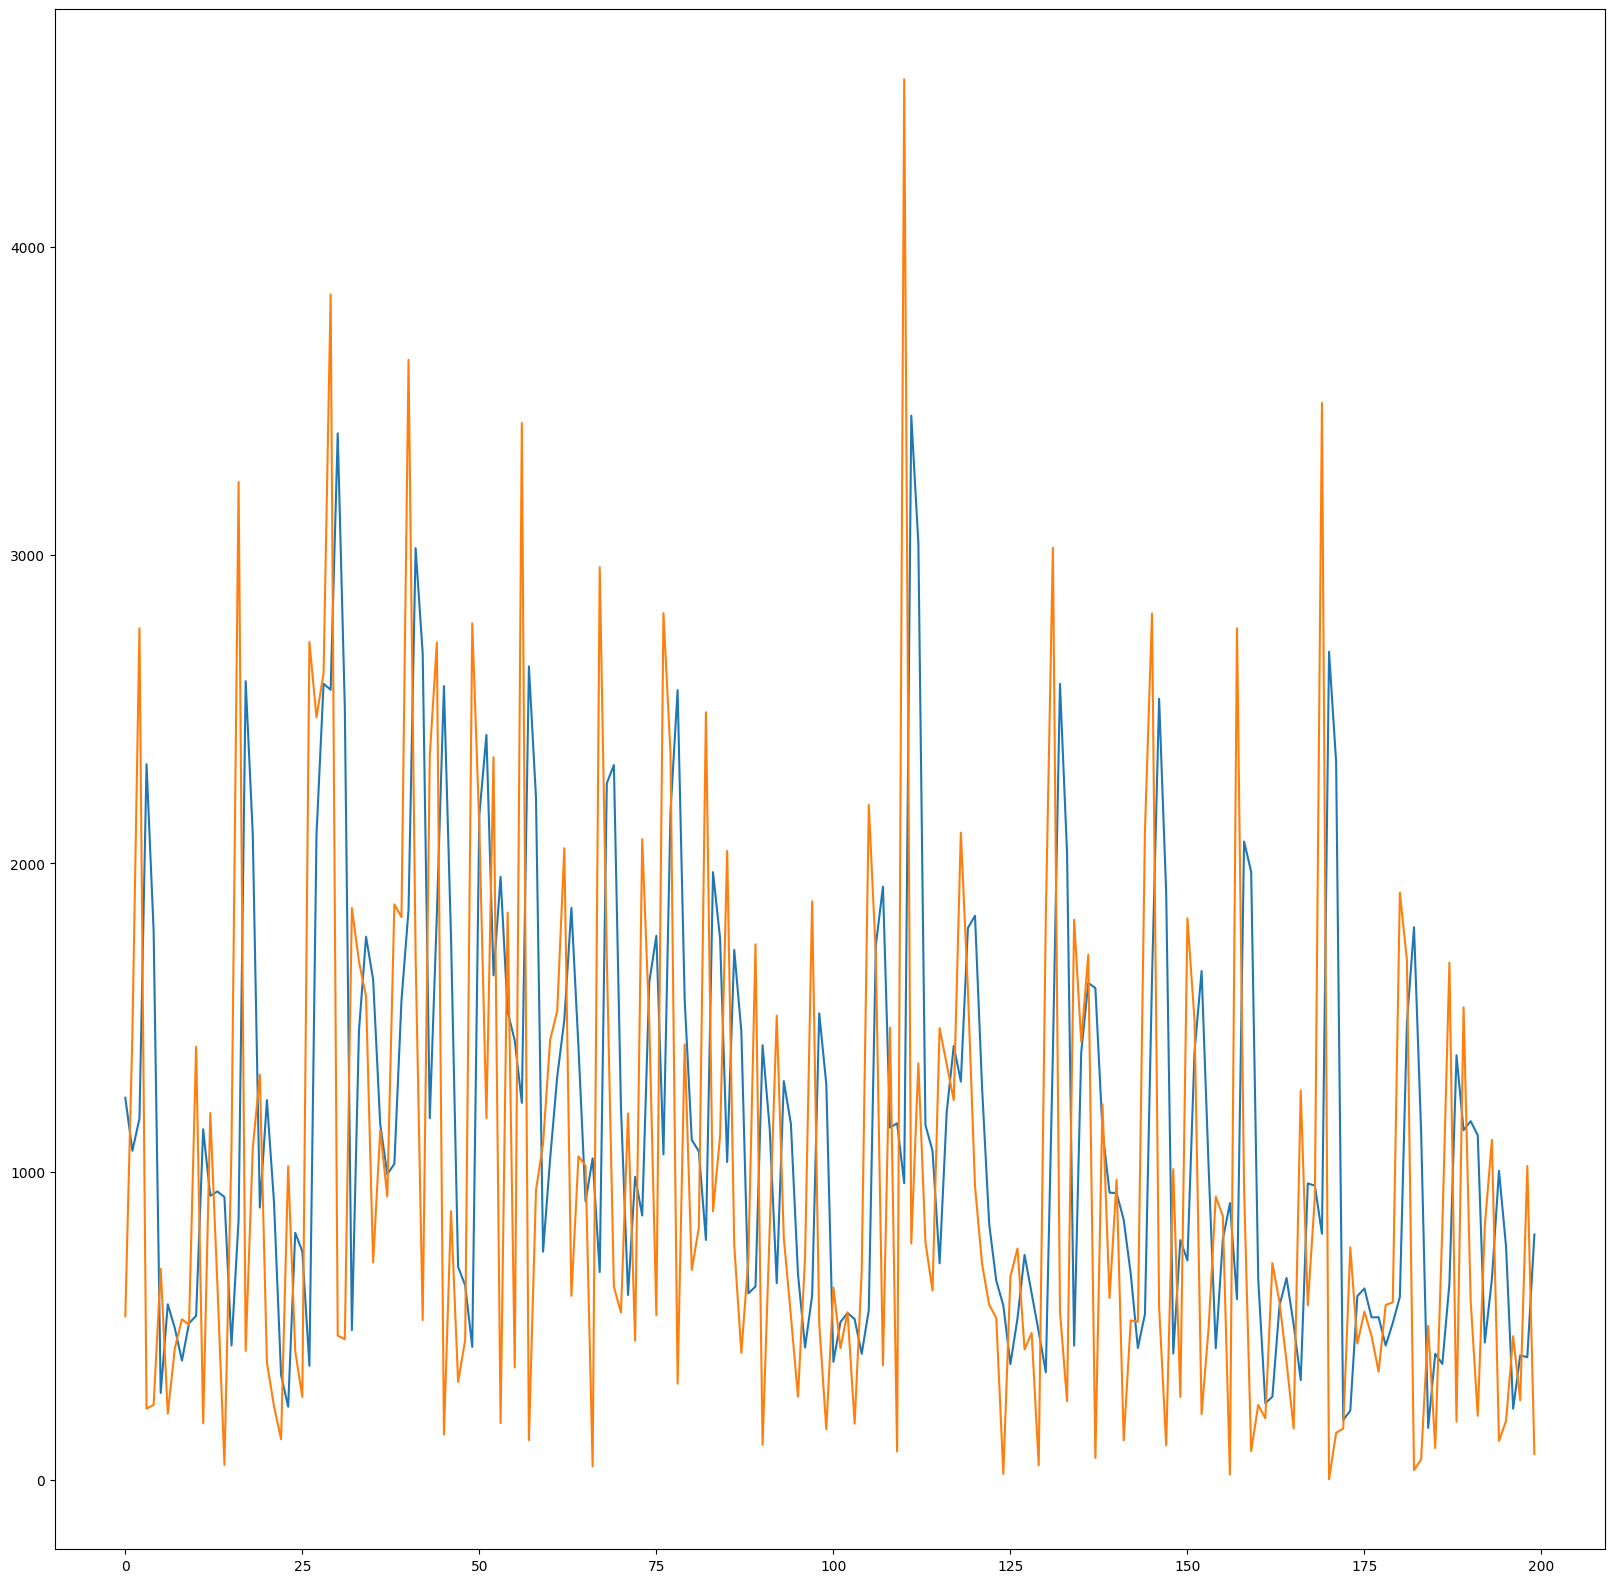

In [35]:
plt.plot(rolling_predictions_arch)
plt.plot(residuals[-test_size:].abs().values)

# Garch

### Lets check Garch at different values of p and q  and select the best one as per AIC and BIC

p =1 and q = 1

In [36]:
model_arch = arch_model(residuals, mean = "zero", vol = "GARCH", p = 1, q = 1, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Iteration:      5,   Func. Count:     28,   Neg. LLF: 20332.87512573044
Iteration:     10,   Func. Count:     56,   Neg. LLF: 20332.74965012404
Iteration:     15,   Func. Count:     81,   Neg. LLF: 20321.16788496589
Iteration:     20,   Func. Count:    113,   Neg. LLF: 24044.920292794173
Iteration:     25,   Func. Count:    143,   Neg. LLF: 29381.0299728166
Iteration:     30,   Func. Count:    173,   Neg. LLF: 18700.066230291493
Iteration:     35,   Func. Count:    199,   Neg. LLF: 18693.18703790215
Iteration:     40,   Func. Count:    251,   Neg. LLF: 18693.256114200092
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18693.1870435146
            Iterations: 45
            Function evaluations: 265
            Gradient evaluations: 41


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Zero Mean - GARCH Model Results                              
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -18693.2
Distribution:      Generalized Error Distribution   AIC:                           37394.4
Method:                        Maximum Likelihood   BIC:                           37418.2
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2881
Time:                                    11:42:32   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.2516      0.548      2.282  2.249e-02   [  0.177,  2.327]
alpha[1]       0.0959  7.166e-03     13.386  7.332e-41 [8.187e-02,  0.110]
beta[1]        0.9041  8.005e-03    112.946      0.000   [  0.888,  0.920]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0756  4.080e-02     26.366 3.368e-153 [  0.996,  1.156]
========================================================================

Covariance estimator: robust
"""

p = 2 and q = 1

In [37]:
model_arch = arch_model(residuals, mean = "zero", vol = "GARCH", p = 2, q = 1, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 20251.85867921194
Iteration:     10,   Func. Count:     64,   Neg. LLF: 20251.77846373488
Iteration:     15,   Func. Count:     94,   Neg. LLF: 20190.140127127102
Iteration:     20,   Func. Count:    131,   Neg. LLF: 28063.503478540664
Iteration:     25,   Func. Count:    166,   Neg. LLF: 28431.62871850218
Iteration:     30,   Func. Count:    200,   Neg. LLF: 18698.06277298371
Iteration:     35,   Func. Count:    231,   Neg. LLF: 18693.18996198544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18693.189539260435
            Iterations: 38
            Function evaluations: 259
            Gradient evaluations: 38


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Zero Mean - GARCH Model Results                              
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -18693.2
Distribution:      Generalized Error Distribution   AIC:                           37396.4
Method:                        Maximum Likelihood   BIC:                           37426.2
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2881
Time:                                    11:42:33   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.2523      0.563      2.226  2.603e-02      [  0.150,  2.355]
alpha[1]       0.0959  2.358e-02      4.068  4.733e-05    [4.971e-02,  0.142]
alpha[2]   7.2059e-11  2.612e-02  2.759e-09      1.000 [-5.119e-02,5.119e-02]
beta[1]        0.9041  9.147e-03     98.834      0.000      [  0.886,  0.922]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0756  4.047e-02     26.576 1.292e-155 [  0.996,  1.155]
========================================================================

Covariance estimator: robust
"""

p = 2 and q = 2

In [38]:
model_arch = arch_model(residuals, mean = "zero", vol = "GARCH", p = 2, q = 2, dist = "ged")
results_arch = model_arch.fit(update_freq = 5)
results_arch.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 20191.583646321935
Iteration:     10,   Func. Count:     75,   Neg. LLF: 20187.9418410403
Iteration:     15,   Func. Count:    110,   Neg. LLF: 20187.762254302786
Iteration:     20,   Func. Count:    145,   Neg. LLF: 20149.8024870538
Iteration:     25,   Func. Count:    182,   Neg. LLF: 19966.578010042504
Iteration:     30,   Func. Count:    227,   Neg. LLF: 18774.163513357882
Iteration:     35,   Func. Count:    265,   Neg. LLF: 18692.72768041172
Iteration:     40,   Func. Count:    313,   Neg. LLF: 18835.827995259075
Iteration:     45,   Func. Count:    353,   Neg. LLF: 18691.096914217065
Iteration:     50,   Func. Count:    394,   Neg. LLF: 18691.126167842933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18691.09215779635
            Iterations: 56
            Function evaluations: 409
            Gradient evaluations: 52


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Zero Mean - GARCH Model Results                              
==========================================================================================
Dep. Variable:                               None   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -18691.1
Distribution:      Generalized Error Distribution   AIC:                           37394.2
Method:                        Maximum Likelihood   BIC:                           37430.0
                                                    No. Observations:                 2881
Date:                            Thu, Aug 22 2024   Df Residuals:                     2881
Time:                                    11:42:33   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.6163      2.448      0.660      0.509    [ -3.181,  6.413]
alpha[1]       0.1299  8.784e-02      1.478      0.139 [-4.229e-02,  0.302]
alpha[2]   4.3919e-07      0.187  2.345e-06      1.000    [ -0.367,  0.367]
beta[1]        0.5094      1.091      0.467      0.641    [ -1.630,  2.648]
beta[2]        0.3607      0.970      0.372      0.710    [ -1.541,  2.263]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.0784  4.628e-02     23.301 4.337e-120 [  0.988,  1.169]
========================================================================

Covariance estimator: robust
"""

*increasing the lag order, all the alphas and betas are becoming insignificant for Garch*

## Rolling Forecast - GARCH

In [39]:
rolling_predictions_garch = []
for i in range(test_size):
    train = residuals[:-(test_size-i)]
    model = arch_model(train, p=1,q = 1, vol = 'garch',mean = 'zero' )
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions_garch.append(np.sqrt(pred.variance.values[-1,:][0]))

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr

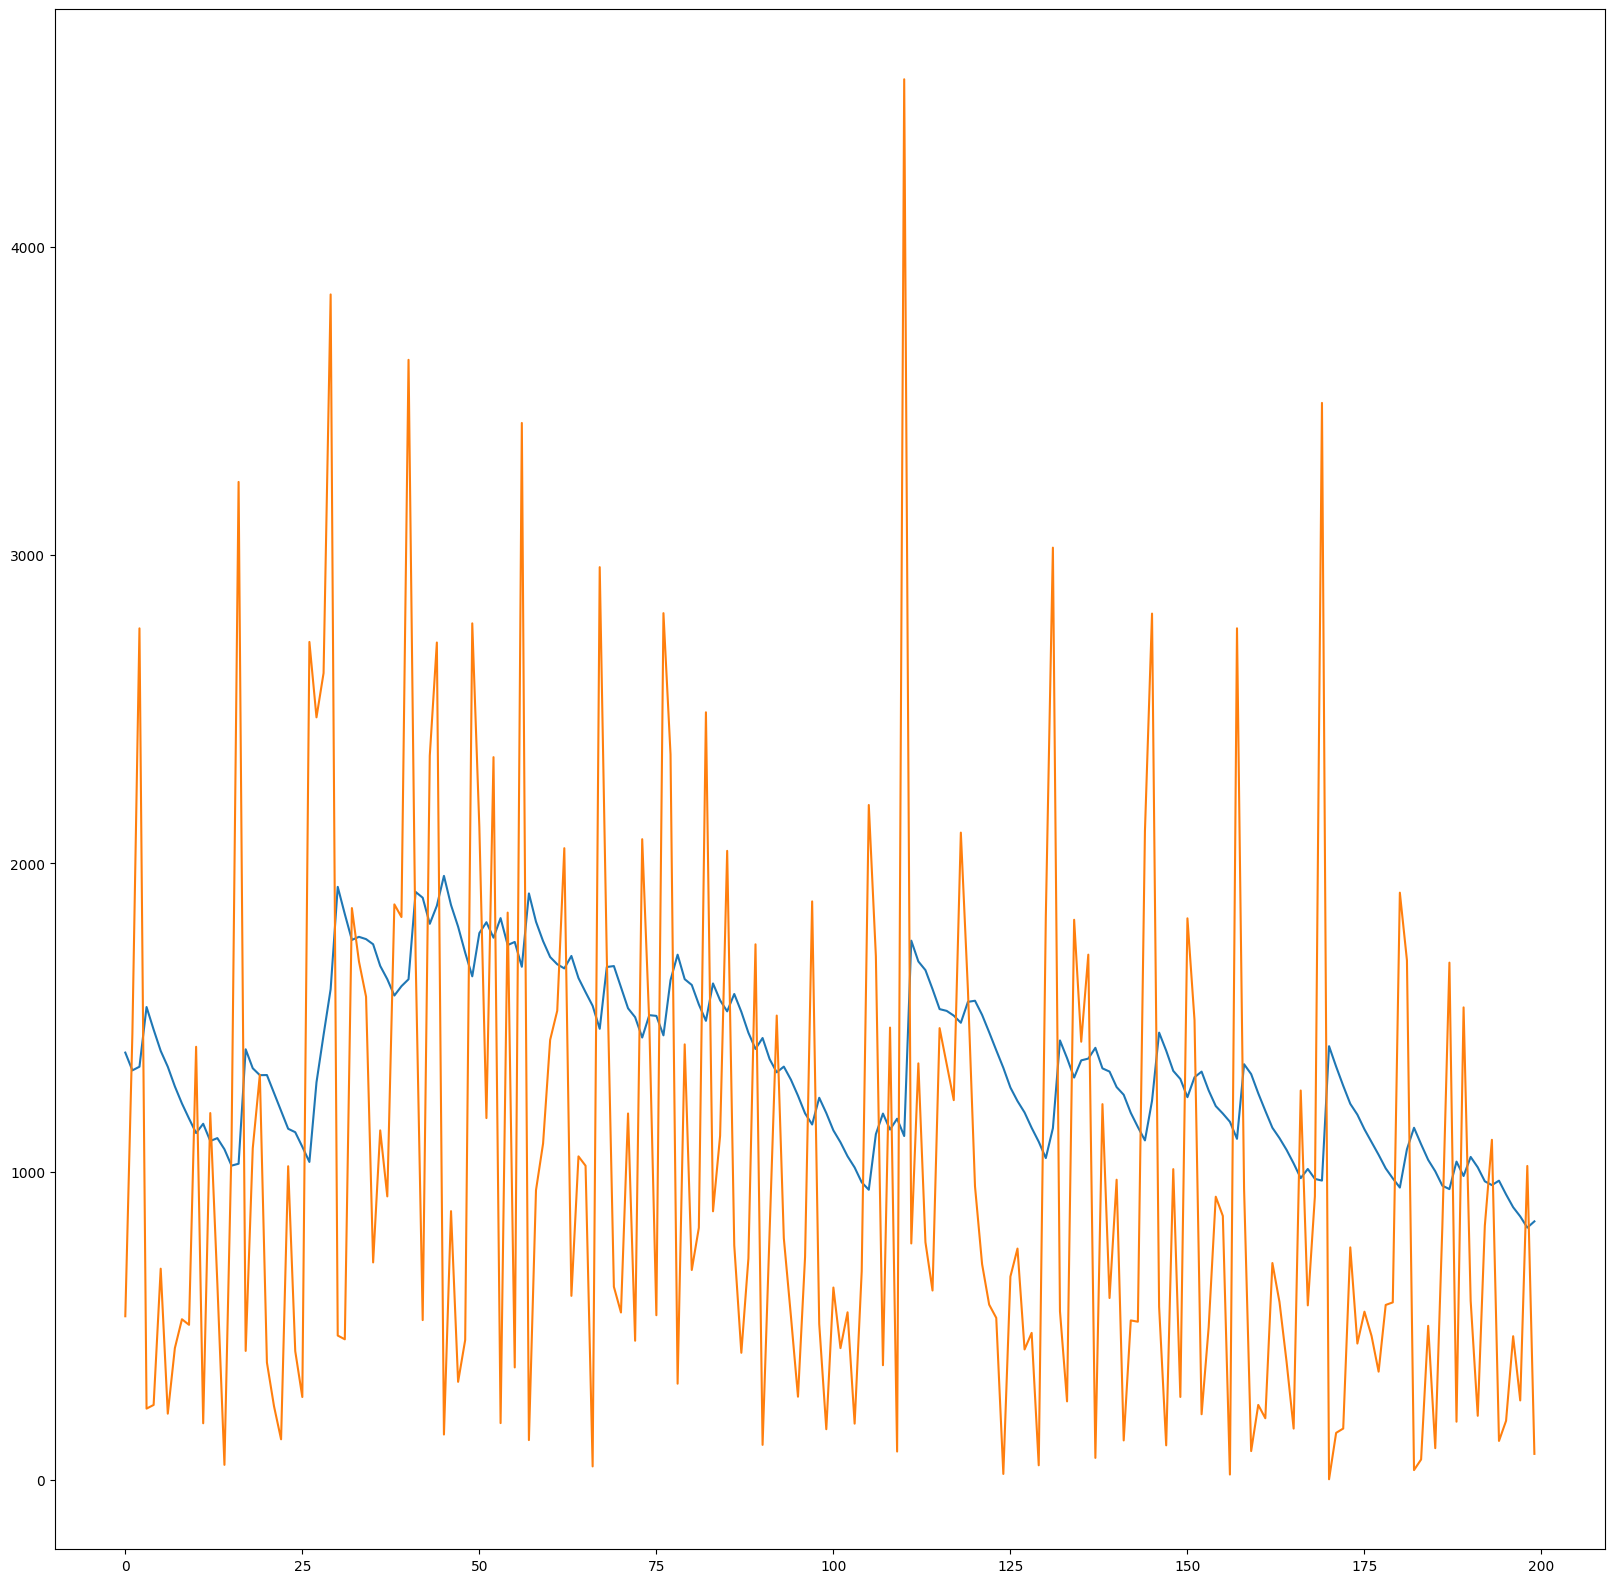

In [40]:
plt.plot(rolling_predictions_garch)
plt.plot(residuals[-test_size:].abs().values)

# Robustness Check

## Structural Breaks - The CUSUM Test

The CUSUM test is based on the recursive least square estimation of the model

![image.png](attachment:image.png)

The CUSUM test statistic is computed from the one-step-ahead residuals of the recursive least squares model. It is based on the intuition that if  Beta changes from one period to the next then the one-step-ahead forecast will not be accurate and the forecast error will be greater than zero.

In [41]:
cusum = sm.stats.diagnostic.breaks_cusumolsresid(residuals, ddof=5)
print(f'test statistic of CUSUM test: {cusum[0]}')
print(f'p value of CUSUM test: {cusum[1]}')

test statistic of CUSUM test: 0.4312355743423596
p value of CUSUM test: 0.9923575655092


#### Structural Breaks - Cusum test hypothesis
H0:  There is no structural change

HA: There is a structural change

At p-value > alpha = 0.05, we can not reject the null hypothesis at 95% confidence level.

This means that, the residuals have no structural breaks as per the cucum test